In [16]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    log_loss,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
import warnings


In [96]:
# Lecture du fichier CSV
data = pd.read_csv('C:/workspace/Machine Learning (Mme Imen Boukhris)/HCV-Egy-Data.csv')

In [97]:
# Vérifier la liste des colonnes
print(data.columns)

Index(['Age ', 'Gender', 'BMI', 'Fever', 'Nausea/Vomting', 'Headache ',
       'Diarrhea ', 'Fatigue & generalized bone ache ', 'Jaundice ',
       'Epigastric pain ', 'WBC', 'RBC', 'HGB', 'Plat', 'AST 1', 'ALT 1',
       'ALT4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24 w',
       'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF',
       'Baseline histological Grading', 'Baselinehistological staging'],
      dtype='object')


In [98]:
print(data.head())
print(data.info())

   Age   Gender  BMI  Fever  Nausea/Vomting  Headache   Diarrhea   \
0    56       1   35      2               1          1          1   
1    46       1   29      1               2          2          1   
2    57       1   33      2               2          2          2   
3    49       2   33      1               2          1          2   
4    59       1   32      1               1          2          1   

   Fatigue & generalized bone ache   Jaundice   Epigastric pain   ...  ALT 36  \
0                                 2          2                 2  ...       5   
1                                 2          2                 1  ...      57   
2                                 1          1                 1  ...       5   
3                                 1          2                 1  ...      48   
4                                 2          2                 2  ...      94   

   ALT 48  ALT after 24 w  RNA Base   RNA 4   RNA 12  RNA EOT  RNA EF  \
0       5               5

In [99]:
# Fonction pour remplacer les valeurs dans les colonnes spécifiées
def replace_values_with_nan(df, columns, value):
    df[columns] = df[columns].replace(value, np.nan)

# Fonction pour gérer les outliers
def handle_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), df[column].median(), df[column])

# Fonction pour effectuer les pré-traitements sur les colonnes numériques
def preprocess_numeric_columns(df, columns):
    for col in columns:
        handle_outliers(df, col)

# Fonction pour effectuer l'encodage des variables catégorielles
def encode_categorical_columns(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])

# Fonction pour remplacer les NaN par la médiane
def impute_nan_with_median(df, columns):
    imputer = SimpleImputer(strategy='median')
    df[columns] = imputer.fit_transform(df[columns])

# Fonction pour nettoyer les données
def clean_data(df):
    # Remplacer le numéro 5 par NaN dans les colonnes de "WBC" à "RNA EF"
    columns_to_replace = df.columns[df.columns.get_loc('WBC'):df.columns.get_loc('RNA EF') + 1]
    df[columns_to_replace] = df[columns_to_replace].replace(5, np.nan)
    # Traiter les types de données (nettoyage de toutes les colonnes numériques)
    for col in df.select_dtypes(include=['number']).columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = detect_outliers(df[col])
        # Ajouter cette ligne pour remplacer les NaN par la médiane dans les colonnes spécifiques
        df[col] = SimpleImputer(strategy='median').fit_transform(df[col].values.reshape(-1, 1)).ravel()

    # Traiter les variables catégorielles
    categorical_columns = df.select_dtypes(include=['object']).columns
    encode_categorical_columns(df, categorical_columns)

    return df

# Nettoyage des données
data = clean_data(data)
print(data_cleaned.head())


   Age   Gender   BMI  Fever  Nausea/Vomting  Headache   Diarrhea   \
0  56.0     1.0  35.0    2.0             1.0        1.0        1.0   
1  46.0     1.0  29.0    1.0             2.0        2.0        1.0   
2  57.0     1.0  33.0    2.0             2.0        2.0        2.0   
3  49.0     2.0  33.0    1.0             2.0        1.0        2.0   
4  59.0     1.0  32.0    1.0             1.0        2.0        1.0   

   Fatigue & generalized bone ache   Jaundice   Epigastric pain   ...  ALT 36  \
0                               2.0        2.0               2.0  ...    84.0   
1                               2.0        2.0               1.0  ...    57.0   
2                               1.0        1.0               1.0  ...    84.0   
3                               1.0        2.0               1.0  ...    48.0   
4                               2.0        2.0               2.0  ...    94.0   

   ALT 48  ALT after 24 w   RNA Base     RNA 4    RNA 12   RNA EOT    RNA EF  \
0    84.0   

Résultats pour la classe binaire 1.0:
                     Accuracy  F1 Score  Precision    Recall
Random Forest        0.606498  0.606498   0.606498  0.606498
Gradient Boosting    0.595668  0.595668   0.595668  0.595668
Decision Tree        0.559567  0.559567   0.559567  0.559567
SVM                  0.545126  0.545126   0.545126  0.545126
K-Nearest Neighbors  0.570397  0.570397   0.570397  0.570397
Naive Bayes          0.570397  0.570397   0.570397  0.570397
Metrics              0.756689  0.430744   0.378615  0.499524




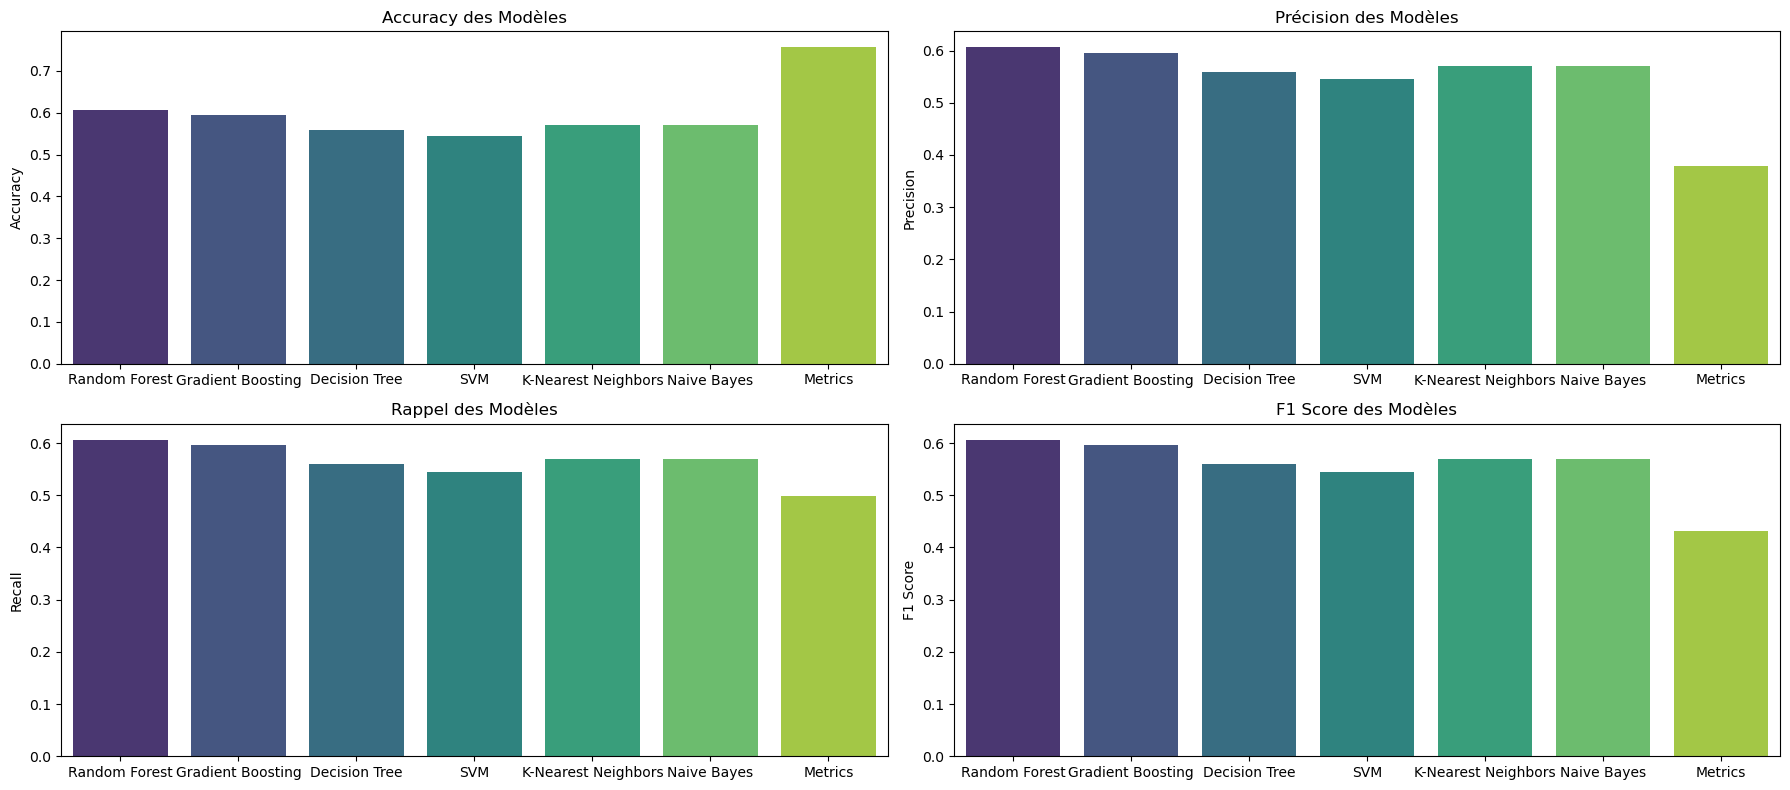

Résultats pour la classe binaire 2.0:
                     Accuracy  F1 Score  Precision    Recall
Random Forest        0.642599  0.642599   0.642599  0.642599
Gradient Boosting    0.729242  0.729242   0.729242  0.729242
Decision Tree        0.606498  0.606498   0.606498  0.606498
SVM                  0.512635  0.512635   0.512635  0.512635
K-Nearest Neighbors  0.545126  0.545126   0.545126  0.545126
Naive Bayes          0.530686  0.530686   0.530686  0.530686
Metrics              0.759571  0.431676   0.380057  0.499524




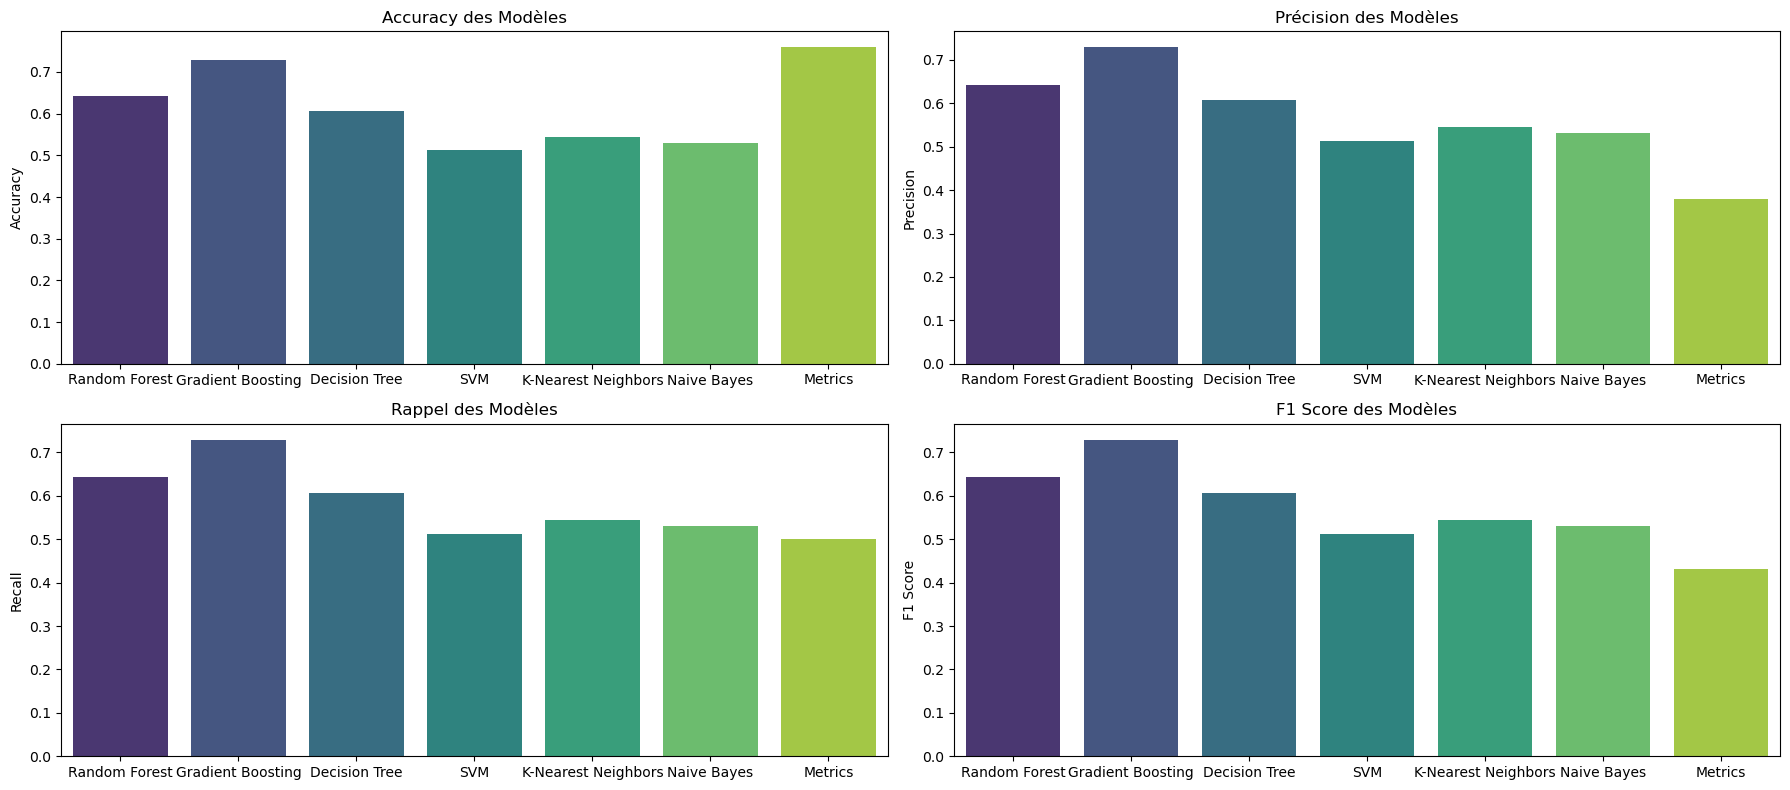

Résultats pour la classe binaire 3.0:
                     Accuracy  F1 Score  Precision    Recall
Random Forest        0.555957  0.555957   0.555957  0.555957
Gradient Boosting    0.541516  0.541516   0.541516  0.541516
Decision Tree        0.537906  0.537906   0.537906  0.537906
SVM                  0.534296  0.534296   0.534296  0.534296
K-Nearest Neighbors  0.559567  0.559567   0.559567  0.559567
Naive Bayes          0.541516  0.541516   0.541516  0.541516
Metrics              0.744417  0.429459   0.422118  0.501429




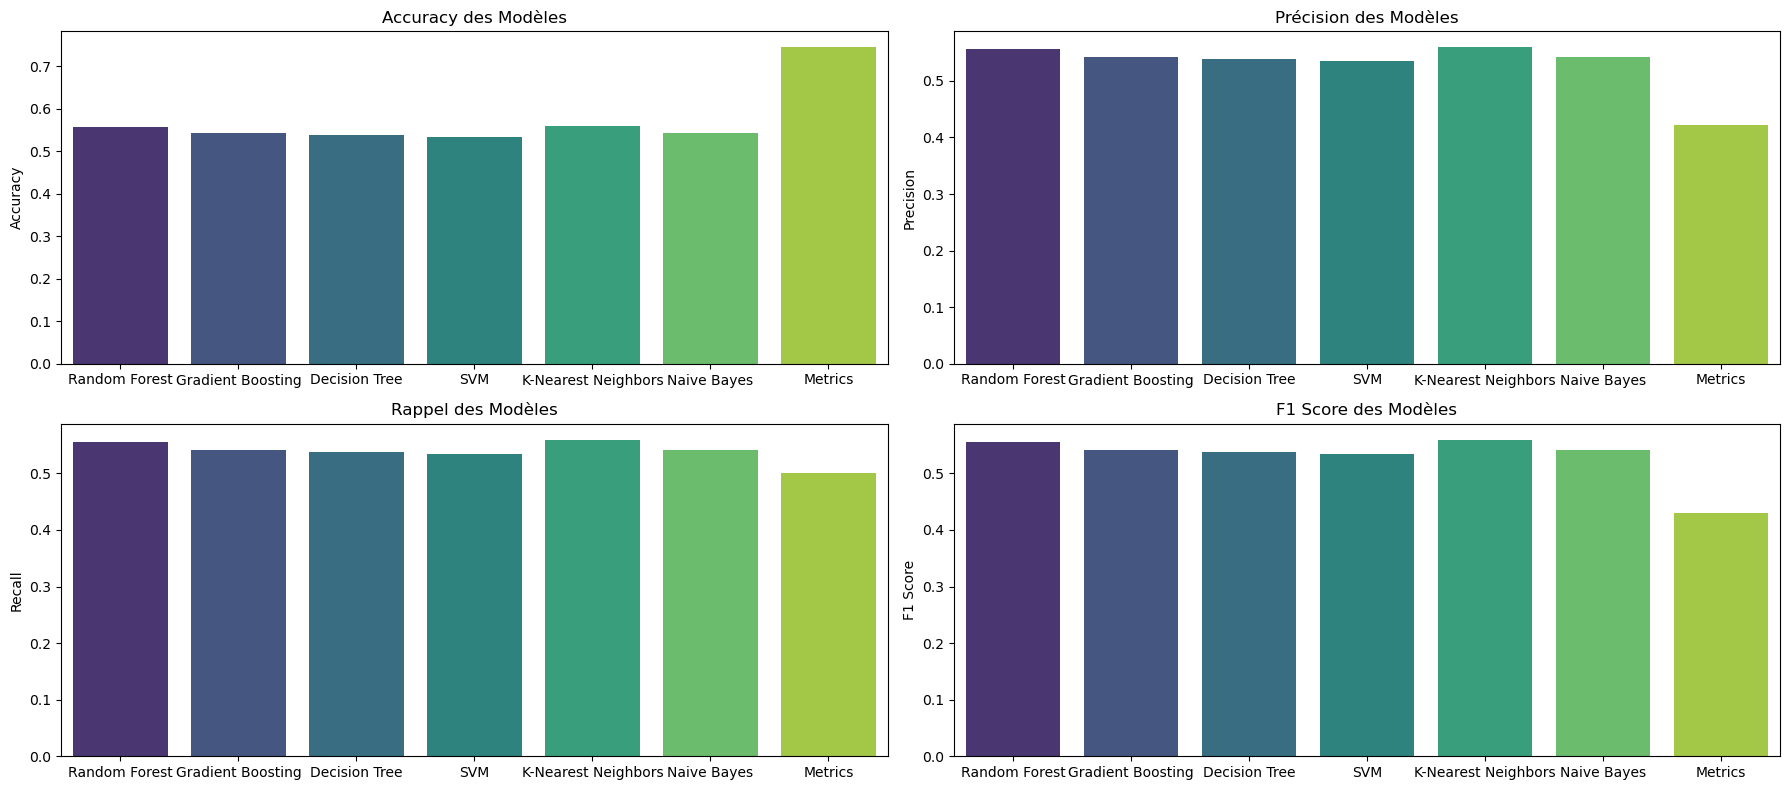

Résultats pour la classe binaire 4.0:
                     Accuracy  F1 Score  Precision    Recall
Random Forest        0.660650  0.660650   0.660650  0.660650
Gradient Boosting    0.657040  0.657040   0.657040  0.657040
Decision Tree        0.563177  0.563177   0.563177  0.563177
SVM                  0.505415  0.505415   0.505415  0.505415
K-Nearest Neighbors  0.530686  0.530686   0.530686  0.530686
Naive Bayes          0.537906  0.537906   0.537906  0.537906
Metrics              0.735737  0.423871   0.368934  0.498044




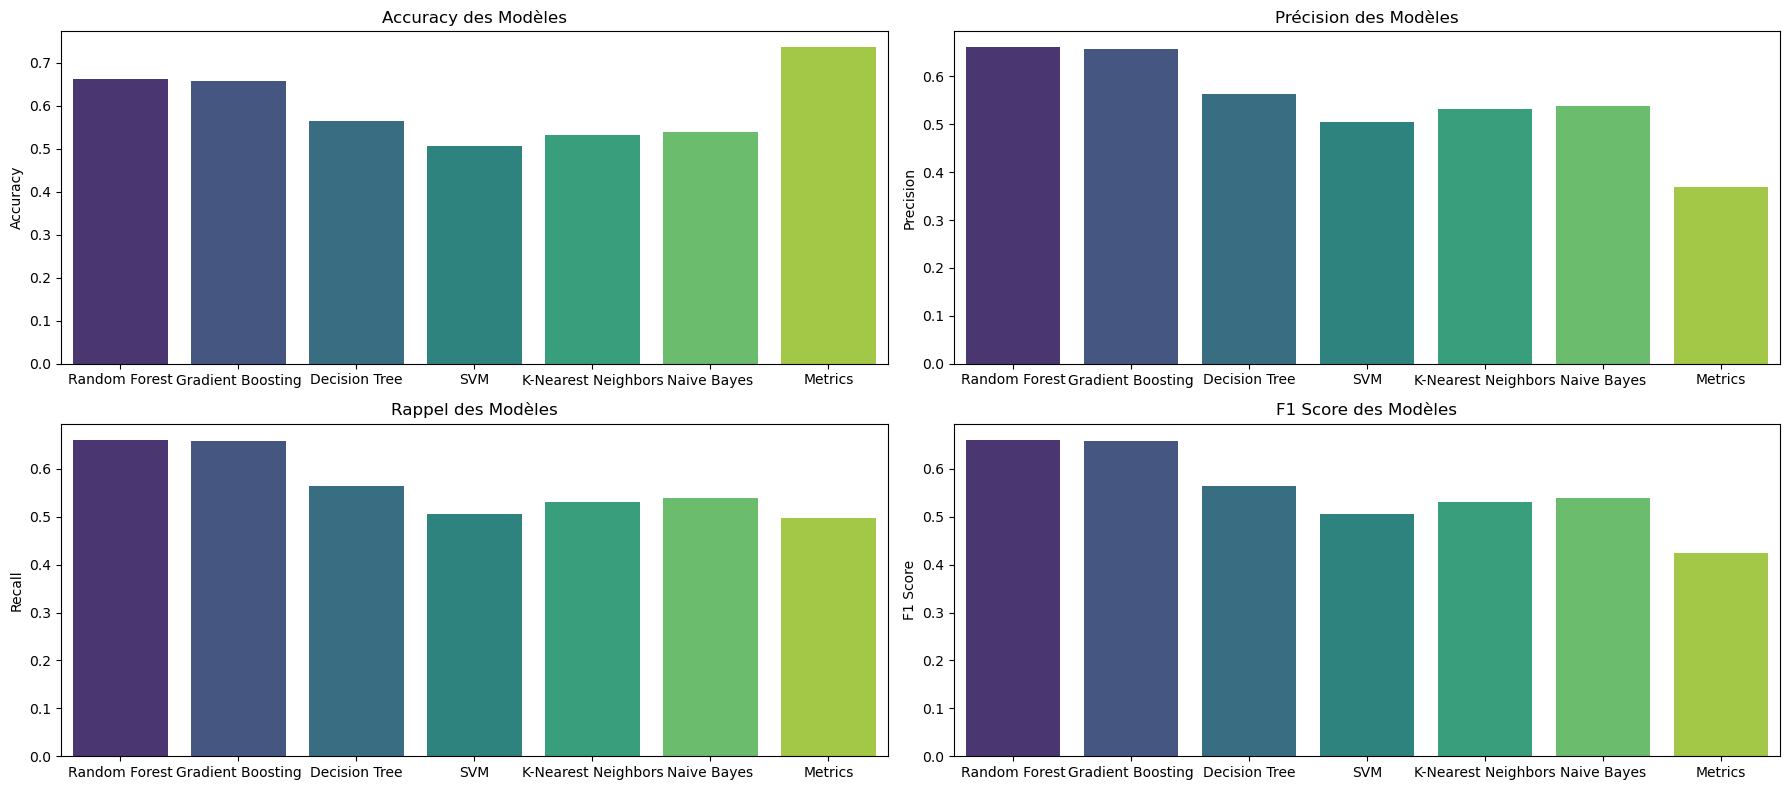

In [103]:
# Identifiez les classes uniques dans la colonne 'Baselinehistological staging' et les convertir en catégorie ordonnée
unique_classes = data['Baselinehistological staging'].astype('category').cat.categories

# Prétraitement et classification pour chaque classe binaire
results_per_class = {}

for current_class in unique_classes:
    # Créez un ensemble binaire pour la classe actuelle
    binary_data = data.copy()
    binary_data['is_class'] = (binary_data['Baselinehistological staging'] == current_class).astype(int)
    scaler = MinMaxScaler()  
    X = binary_data.iloc[:, :-2]  
    X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y = binary_data['is_class']

    # Sélection de caractéristiques
    k_best = SelectKBest(score_func=f_classif, k=5)
    X_selected = k_best.fit_transform(X_normalized, y)

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Gérer le déséquilibre des classes avec SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Modèle de Classification 
    models = {
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "SVM": SVC(probability=True),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Naive Bayes": GaussianNB(),
    }

    results = {}
    
# Entraînement et évaluation du modèle
    for model_name, model in models.items():
        model.fit(X_resampled, y_resampled)
        score = model.score(X_test, y_test)
        results[model_name] = score

    # Classification avec validation croisée Kfold
    # Utilisation de StratifiedKFold pour assurer la distribution égale des classes dans chaque fold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores_accuracy = cross_val_score(model, X_normalized, y, cv=skf, scoring='accuracy')
    scores_precision = cross_val_score(model, X_normalized, y, cv=skf, scoring='precision_macro')
    scores_recall = cross_val_score(model, X_normalized, y, cv=skf, scoring='recall_macro')
    scores_f1 = cross_val_score(model, X_normalized, y, cv=skf, scoring='f1_macro')

    results['Metrics'] = {
        'Accuracy': scores_accuracy.mean(),
        'Precision': scores_precision.mean(),
        'Recall': scores_recall.mean(),
        'F1 Score': scores_f1.mean()
    }

    # Afficher les résultats pour chaque classe binaire
    print(f"Résultats pour la classe binaire {current_class}:")
    results_df = pd.DataFrame(results).T
    print(results_df)
    print("\n")

    # Visualisation des résultats avec un graphique à barres
    plt.figure(figsize=(18, 8))

    # Visualisation des résultats combinés avec des graphiques à barres
    # Accuracy
    plt.subplot(2, 2, 1)
    sns.barplot(x=results_df.index , y='Accuracy', data=results_df, palette='viridis')
    plt.title('Accuracy des Modèles')  
    
    # Precision
    plt.subplot(2, 2, 2)
    sns.barplot(x=results_df.index , y='Precision', data=results_df, palette='viridis')
    plt.title('Précision des Modèles')
    
    # Recall
    plt.subplot(2, 2, 3)
    sns.barplot(x=results_df.index , y='Recall', data=results_df, palette='viridis')
    plt.title('Rappel des Modèles')
    
    # F1 Score
    plt.subplot(2, 2, 4)
    sns.barplot(x=results_df.index , y='F1 Score', data=results_df, palette='viridis')
    plt.title('F1 Score des Modèles')
    plt.tight_layout()
    plt.show()

Best model in terms of global scores: Random Forest
Global score of the best model: 0.6606498194945848
Detailed scores of the best model:
 Accuracy     0.66065
Precision    0.66065
Recall       0.66065
F1 Score     0.66065
Name: Random Forest, dtype: float64
Confusion Matrix for the Best Model:
[[164  39]
 [ 55  19]]


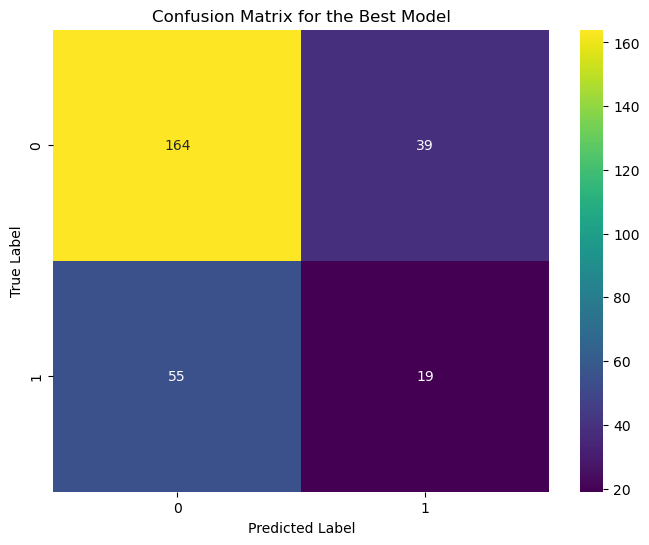

In [108]:
#Calculer le score global pour chaque modèle
results_df['Global Score'] = (
    results_df['Accuracy'] +
    results_df['Precision'] +
    results_df['Recall'] +
    results_df['F1 Score']
) / 4


# Trouver le modèle avec le meilleur score global
best_model = results_df.loc[final_metrics_df['Global Score'].idxmax()]


# Afficher le résultat
print("Best model in terms of global scores:", best_model.name)
print("Global score of the best model:", best_model['Global Score'])
print("Detailed scores of the best model:\n", best_model[['Accuracy', 'Precision', 'Recall', 'F1 Score']])

# Calculer et afficher la matrice de confusion pour le meilleur modèle
best_model_instance = models[best_model.name]
best_model_instance.fit(X_resampled, y_resampled)
y_pred_best_model = best_model_instance.predict(X_test)

# Afficher la matrice de confusion
conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
print("Confusion Matrix for the Best Model:")
print(conf_matrix_best_model)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_model, annot=True, fmt='d', cmap='viridis', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for the Best Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()